In [1]:
####################################################
# Import packages
####################################################
import numpy as np
import copy
import pandas as pd
from plotnine import *
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from plotnine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

####################################################
# Define global vars
####################################################
color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]


####################################################
# Define helper functions
####################################################
def seq(start, stop, by, round_n=3):
    return [round(x, round_n) for x in list(np.arange(start, stop, by))]


def skew(l, round_n=3):
    return round((np.mean(l) - np.median(l)) / np.std(l), round_n)


def lspline(series, knots):
    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix

def create_calibration_plot(
    data,
    file_name,
    prob_var,
    actual_var,
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    if breaks is None:
        breaks = np.around(
            np.linspace(0, (n_bins + 1) / 10, num=n_bins + 1, endpoint=False),
            decimals=1,
        ).tolist()

    data["prob_bin"] = pd.cut(data[prob_var], breaks, right=True, include_lowest=True)

    binned_data = (
        data.groupby("prob_bin")
        .agg(
            mean_prob=(prob_var, "mean"),
            mean_actual=(actual_var, "mean"),
            n=(actual_var, "size"),
        )
        .reset_index()
    )

    plot = (
        ggplot(binned_data, aes("mean_prob", "mean_actual"))
        + geom_line(color=color[0], size=1, show_legend=True)
        + geom_point(
            color=color[0],
            size=1,
            alpha=0.7,
            show_legend=False,
            na_rm=True,
        )
        + geom_segment(
            x=min(breaks),
            xend=max(breaks),
            y=min(breaks),
            yend=max(breaks),
            color=color[1],
            size=0.5,
        )
        + theme_bw()
        + labs(x="Predicted event probability", y=y_lab)
        + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
        + expand_limits(x=0.01, y=0.01)
        + scale_y_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
        + scale_x_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
    )

    return plot


def poly(x, degree=1):
    """
    Fit Polynomial
    These are non orthogonal factors, but it may not matter if
    we only need this for predictions (without interpreting the
    coefficients) or visualisation.
    """
    d = {}
    for i in range(degree+1):
        if i == 1:
            d['x'] = x
        else:
            d[f'x**{i}'] = np.power(x, i)
    return pd.DataFrame(d)


In [2]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from plotnine import *

warnings.filterwarnings("ignore")

In [3]:
# Current script folder
path = os.getcwd()
base_dir = path.split("da_case_studies")[0]

data_dir = base_dir + "da_data_repo"

In [4]:
os.chdir('C:\second year winter')

In [5]:
df= pd.read_csv("cs_bisnode_panel.csv" , header = 0, sep =',')

In [6]:
df.describe()

,comp_id,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,finished_prod,fixed_assets,...,ceo_count,foreign,female,birth_year,inoffice_days,nace_main,ind2,ind,urban_m,labor_avg
count,2.878290e+05,1.825700e+04,2.797890e+05,2.876980e+05,2.876980e+05,2.693000e+05,2.693000e+05,2.706260e+05,1.748500e+04,2.876980e+05,...,231402.000000,231402.000000,231402.000000,176011.000000,231402.000000,286791.000000,286791.000000,278060.000000,287829.000000,141297.000000
mean,1.540862e+11,4.601683e+05,2.353264e+04,2.209395e+05,1.742499e+05,1.521749e+03,3.754458e+03,2.229149e+03,1.056481e+05,3.393731e+05,...,1.254038,0.115653,0.255157,1964.902661,3205.323629,4858.231479,48.353062,2.692023,2.067075,1.009435
std,1.382424e+11,2.614149e+06,8.216668e+05,4.182020e+06,3.730357e+06,7.237342e+04,1.727794e+05,1.611169e+05,5.338053e+05,1.823176e+07,...,0.517837,0.308518,0.406538,11.546875,1880.553038,1250.012437,12.570550,0.512269,0.847473,4.771655
min,1.001034e+06,-8.445704e+05,-3.076704e+05,-5.555556e+05,-7.727111e+05,-4.902703e+05,-2.744074e+05,-6.181263e+06,0.000000e+00,-2.394226e+06,...,1.000000,0.000000,0.000000,1920.000000,1.000000,111.000000,1.000000,1.000000,1.000000,0.000000
25%,2.868635e+10,0.000000e+00,3.333333e+01,2.203704e+03,1.833333e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000,0.000000,0.000000,1956.000000,1775.000000,3314.000000,33.000000,2.000000,1.000000,0.090909
50%,1.152850e+11,7.040741e+03,7.814815e+02,9.592593e+03,1.049259e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.825926e+03,...,1.000000,0.000000,0.000000,1966.000000,2838.000000,5610.000000,56.000000,3.000000,2.000000,0.243056
75%,2.593958e+11,1.063000e+05,4.003704e+03,3.552130e+04,4.101852e+04,0.000000e+00,0.000000e+00,0.000000e+00,3.592592e+02,3.593982e+04,...,1.000000,0.000000,0.500000,1974.000000,4468.750000,5610.000000,56.000000,3.000000,3.000000,0.583333
max,4.641209e+11,9.499693e+07,1.820889e+08,1.299011e+09,1.683374e+09,1.704172e+07,7.233078e+07,7.233078e+07,1.803635e+07,7.940211e+09,...,15.000000,1.000000,1.000000,2016.000000,10983.000000,9609.000000,96.000000,3.000000,3.000000,219.333344


In [7]:
#Import data
csv_path = os.path.join("cs_bisnode_panel.csv")
data = pd.read_csv(csv_path)

In [8]:
# drop variables with many NAs
data = data.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)
data = data.query("year !=2016")

In [9]:
#Label engineering
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN

In [10]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["high_growth_firm"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-2) == 0)
).astype(int)

In [11]:
data = data.query("year <= 2015")

In [12]:
data["sales"].describe()

count    2.706490e+05
mean     4.877188e+05
std      3.871007e+06
min     -1.472559e+07
25%      4.685185e+03
50%      3.028889e+04
75%      1.109185e+05
max      1.110294e+08
Name: sales, dtype: float64

In [13]:
data = data.assign(
    sale_growth=data["sales"].pct_change() * 100,
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

In [14]:
data["sale_growth"] = data["ln_sales"] - data.groupby("comp_id")["ln_sales"].shift(1)

In [15]:
data["sale_growth_target"] = data["sale_growth"].shift(-1)

In [16]:

#data["high_growth_firm"] = np.where(data["sale_growth"] > data["sale_growth"].mean(), 1, 0)
data["high_growth_firm"] = np.where(data["sale_growth"]>0.25,1,0)

In [17]:
data["sale_growth"].describe()

count    220465.000000
mean          0.052471
std           2.626291
min         -16.955884
25%          -0.199125
50%           0.000000
75%           0.268721
max          17.530779
Name: sale_growth, dtype: float64

In [18]:
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)

In [19]:
# replace w 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

In [20]:
data["new"].describe()


count    510532.000000
mean          0.670365
std           0.470081
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

In [21]:
#sample design 
# look at cross section
data = data.query("year == 2012")
# look at firms below 10m euro revenues and above 1000 euros
data = data.query("sales_mil<=10 & sales_mil>=0.001")

In [22]:
data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,status_alive,high_growth_firm,sale_growth,ln_sales,sales_mil,sales_mil_log,sale_growth_target,d1_sales_mil_log,age,new
324885,2012,1.001541e+06,2012-01-01,2012-12-31,481.481476,9.629630e+03,1.303704e+03,0.000000,0.000000,0.000000,...,1,1,7.093159,7.093159,0.001204,-6.722352,0.684448,-6.722352,4.0,0.0
324886,2012,1.002029e+06,2012-01-01,2012-12-31,14929.629883,2.038852e+05,1.204445e+05,0.000000,0.000000,0.000000,...,1,1,0.684448,13.943477,1.136515,0.127966,-1.424773,0.684448,6.0,0.0
324887,2012,1.003200e+06,2012-01-01,2012-12-31,25.925926,2.222222e+01,1.099630e+04,0.000000,0.000000,0.000000,...,1,0,-1.424773,7.932070,0.002785,-5.883441,NaN,-1.424773,9.0,0.0
324891,2012,1.011889e+06,2012-01-01,2012-12-31,36625.925781,1.601667e+05,1.891111e+04,0.000000,0.000000,0.000000,...,1,0,0.097722,12.980031,0.433667,-0.835479,-0.273087,0.097722,20.0,0.0
324892,2012,1.014183e+06,2012-01-01,2012-12-31,12551.851562,1.999037e+05,8.274074e+03,0.000000,7.407407,7.407407,...,1,0,-0.273087,11.773208,0.129730,-2.042303,-0.019100,-0.273087,11.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371285,2012,4.638854e+11,2012-01-01,2012-12-31,544.444458,1.437407e+04,1.330000e+04,0.000000,0.000000,0.000000,...,1,0,-0.234990,11.958560,0.156148,-1.856950,NaN,-0.234990,3.0,0.0
371288,2012,4.639820e+11,2012-01-01,2012-12-31,16337.037109,3.140000e+04,8.300000e+03,0.000000,0.000000,0.000000,...,1,0,-0.844769,12.159136,0.190830,-1.656374,NaN,-0.844769,17.0,0.0
371290,2012,4.640212e+11,2012-01-01,2012-12-31,3566.666748,3.149630e+04,1.783704e+04,0.000000,0.000000,0.000000,...,1,0,-0.282607,10.546608,0.038048,-3.268903,0.294490,-0.282607,6.0,0.0
371291,2012,4.640446e+11,2012-01-01,2012-12-31,76059.257812,4.776548e+06,1.297552e+06,0.000000,0.000000,0.000000,...,1,1,0.294490,15.959566,8.533974,2.144055,NaN,0.294490,4.0,0.0


In [23]:
#Feature engineering
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

In [24]:
data.groupby("ind2_cat").count()["comp_id"]


ind2_cat
20.0       50
26.0     1080
27.0      660
28.0     1954
29.0      287
30.0      168
32.0      148
33.0     1944
40.0      208
55.0     2266
56.0    12711
60.0      242
99.0        5
Name: comp_id, dtype: int64

In [25]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

In [26]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    21700
1.0       13
Name: comp_id, dtype: int64

In [27]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [28]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count    2.171300e+04
mean     2.525889e+05
std      1.383198e+06
min      0.000000e+00
25%      6.466667e+03
50%      2.382963e+04
75%      9.346296e+04
max      1.046833e+08
Name: total_assets_bs, dtype: float64

In [29]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]

In [30]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [31]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )

In [32]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [33]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)

In [34]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)

In [35]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)

In [36]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

In [37]:
data["labor_avg"].describe()

count    18569.000000
mean         0.621691
std          1.586800
min          0.083333
25%          0.097222
50%          0.229167
75%          0.513889
max         42.118057
Name: labor_avg, dtype: float64

In [38]:
data["labor_avg_mod"].describe()

count    21723.000000
mean         0.621691
std          1.467084
min          0.083333
25%          0.125000
50%          0.284722
75%          0.621691
max         42.118057
Name: labor_avg_mod, dtype: float64

In [39]:
data = data.drop(["labor_avg"], axis=1)

In [40]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

In [43]:
# Linear regressions
ols_s = smf.ols("high_growth_firm ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:       high_growth_firm   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     12.03
Date:                Fri, 10 Mar 2023   Prob (F-statistic):           5.99e-06
Time:                        13:45:28   Log-Likelihood:                -13100.
No. Observations:               21723   AIC:                         2.621e+04
Df Residuals:                   21720   BIC:                         2.623e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2690      0.007  

In [44]:
########################################################################
# sales change
########################################################################
# Note: graphs not in book

# lowess
data["d1_sales_mil_log"].describe()

count    21723.000000
mean        -0.077675
std          0.842694
min         -6.889406
25%         -0.158513
50%          0.000000
75%          0.103433
max          7.880300
Name: d1_sales_mil_log, dtype: float64

In [46]:
# generate variables ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2

In [47]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])

In [48]:
# drop missing
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()

count    19036.000000
mean         8.701828
std          6.924531
min          0.000000
25%          2.000000
50%          7.000000
75%         15.000000
max         34.000000
Name: age, dtype: float64

In [49]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()

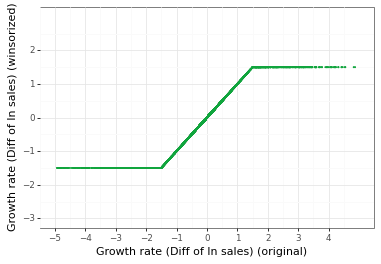

<ggplot: (117886210052)>

In [51]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="d1_sales_mil_log_mod"))
    + geom_point(size=0.1, color=color[1])
    + labs(
        x="Growth rate (Diff of ln sales) (original)",
        y="Growth rate (Diff of ln sales) (winsorized)",
    )
    + scale_x_continuous(limits=(-5, 5), breaks=seq(-5, 5, by=1))
    + scale_y_continuous(limits=(-3, 3), breaks=seq(-3, 3, by=1))
    + theme_bw()
)

In [52]:
data.to_csv("first attempt clean.csv", index=False)